In [1]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
import numpy as np
from selfplaylab.game.go import CaptureGoState, PixelCaptureGoState
from selfplaylab.game.nim import NimState

In [6]:
game_cls = PixelCaptureGoState
tags =["kl","kl_lr","aux_force_win","aux_force_win_kl","aux_force_win_kl_lr"]
tags = ["pcr","pcr_kl"]
tags = ["pcr_kl_rfi"]

loss_keys = ["value", "policy","aux_policy"]
scales = {"value": (0, 0.5), "policy": [0, 4.5], "aux_policy": [0, 0.75]}
maxmove = 50
show_iter = True

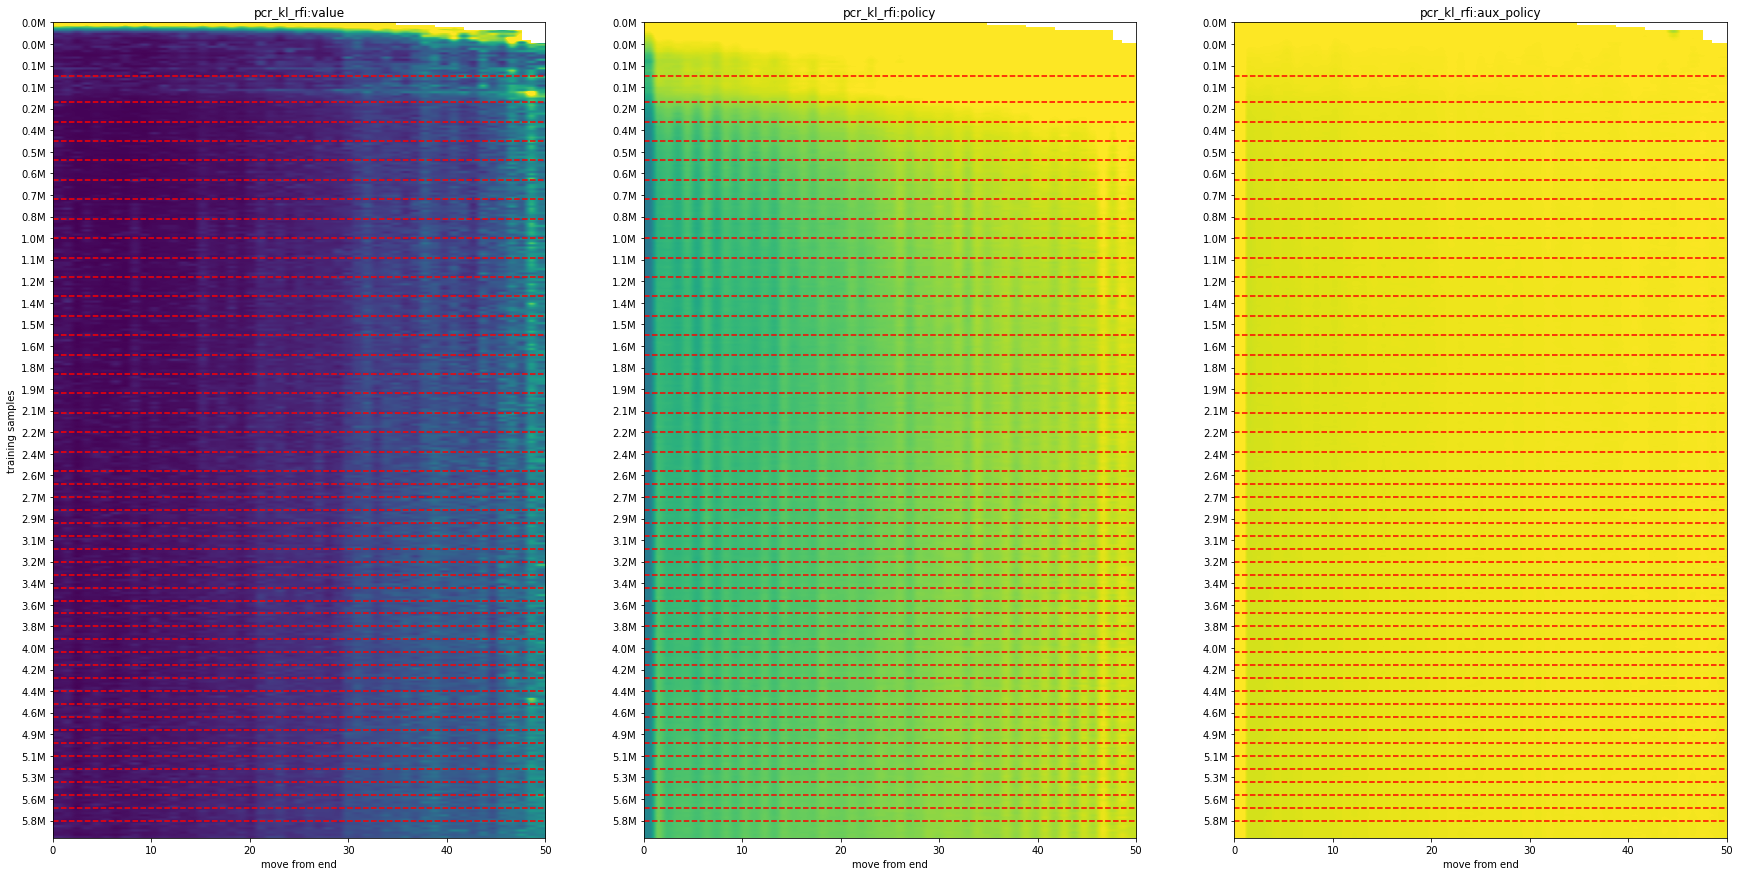

In [7]:
plt.figure(figsize=(30, 15))
npl = len(tags) * len(loss_keys)

losses_by_tag = defaultdict(dict)
lossgrid_by_tag = defaultdict(dict)
num_by_tag = {}

cumsum_samples= {}
for it, tag in enumerate(tags):
    last_net = game_cls.create_net(tag=tag)
    loss_data = last_net.metadata["losses_per_epoch"]
    for ik, k in enumerate(loss_keys):
        mn, mx = scales[k]
        loss_per_epoch = loss_data[k]
        loss_grid = np.full((len(loss_per_epoch), 100), np.nan)
        num = np.full((len(loss_per_epoch), 100), 0)
        for i, ve in enumerate(loss_per_epoch):
            for m, (l, n) in ve.items():
                loss_grid[i, m] = l
                num[i, m] = n

        nnl = np.nan_to_num(loss_grid)
        losses_by_tag[k][tag] = np.sum(nnl * num, axis=1) / np.sum(num,axis=1)
        lossgrid_by_tag[k][tag] = nnl
        num_by_tag[tag] = num
        ax = plt.subplot(1, npl, ik * len(tags) + it + 1)
        ax.imshow(
            loss_grid[:, : maxmove + 1],
            vmin=mn,
            vmax=mx,
            aspect="auto",
            extent=[0, maxmove, len(loss_per_epoch), 0],
        )
        ix = np.arange(0, len(loss_per_epoch), 10)
        cumsum_samples[tag] = np.cumsum(last_net.metadata["stats_per_epoch"]["samples"])
        lbl = [
            f"{s/1e6:.1f}M"
            for s in cumsum_samples[tag][ix]
        ]
        plt.yticks(ticks=ix, labels=lbl)
        if ik + it == 0:
            plt.ylabel("training samples")
        plt.xlabel("move from end")
        plt.title(f"{tag}:{k}")
        if show_iter:
            (iter_ix,) = np.where(
                np.diff(last_net.metadata["stats_per_epoch"]["iteration"]) > 0
            )
            for i in iter_ix:
                ax.plot([0, maxmove], [i - 1, i - 1], "r--")

In [5]:
last_net.metadata

{'filename': 'data/PixelCaptureGo(13x13)pcr/1597950871/net.pt',
 'parent': None,
 'game_cls': selfplaylab.game.go.PixelCaptureGoState,
 'iteration': 1,
 'tag': 'pcr'}

KeyError: 'pcr'

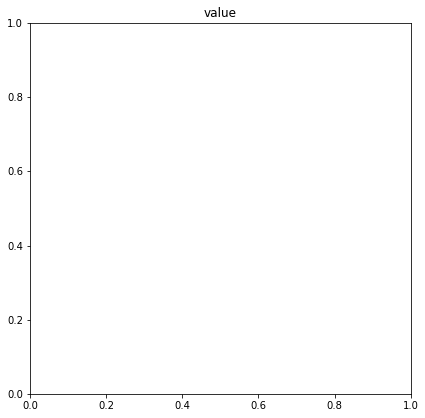

In [4]:
plt.figure(figsize=(15,15))
for ik,k in enumerate(loss_keys):
    plt.subplot(2,2,ik+1)
    plt.title(k)
    for it, tag in enumerate(tags):
        plt.plot(cumsum_samples[tag],losses_by_tag[k][tag])
        plt.xlabel('samples')
        plt.legend(tags)

11232
10824


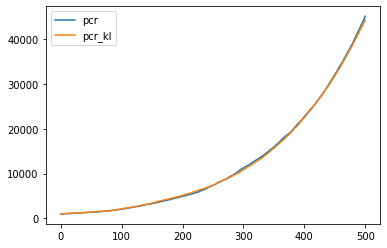

In [5]:
for it, tag in enumerate(tags):
    last_net = game_cls.create_net(tag=tag)
    plt.plot(last_net.metadata['stats_per_epoch']['samples'])
    print(last_net.metadata['stats_per_epoch']['samples'][300])
plt.legend(tags)

In [6]:
plt.imshow(num_by_tag['nw_kl'])

KeyError: 'nw_kl'

In [ ]:
for k,a in num_by_tag.items():
    plt.plot(a[300,:])
    print(sum(a[300,:]))
plt.legend(num_by_tag.keys())    